# House price prediction
## Просмотр данных

In [49]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [50]:
train = pd.read_csv('./data/train.csv', index_col='Id')
test = pd.read_csv('./data/train.csv', index_col='Id')
train.columns.values # Список столбцов

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDriv

In [51]:
train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

## Первичная обработка данных
### Работа с пропущенными значениями

<AxesSubplot: >

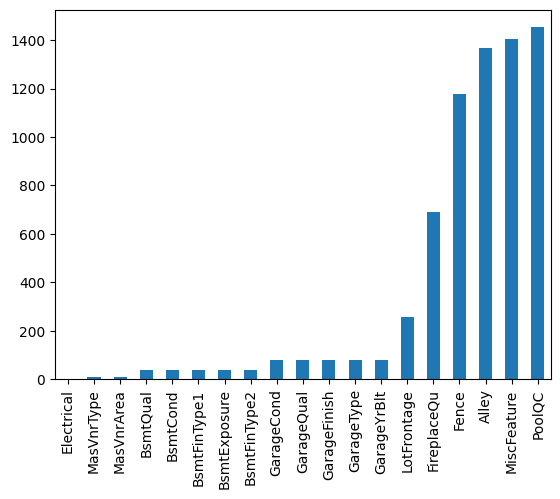

In [52]:
missing = train.isnull().sum() # 
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

В данных(как для тестовых, так и для тренировочных) есть 19 атрибутов имеющих пропущенные значения, из них 5 имеющих более 50% всех данных. В некоторых случаях NA означает отсутствие предмета, описываемого атрибутом, например, отсутствие бассейна, забора, отсутствия гаража и подвала. А в других - параметры этих предметов.

Заменим пропущенные значения на None(если тип данных категориальный) и на 0(если он числовой).
Заменим значения Na столбца Functional на typical — 'Typ'.

In [53]:
def na_to_none(data): # Меняет Na на None, 0 и Typ
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu' ):
        data[col] = data[col].fillna('None')
    for col in  ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        data[col] = data[col].fillna(0)
    data["Functional"] = data["Functional"].fillna("Typ")
    return data

train = na_to_none(train)
test = na_to_none(test)

Для следующих входных переменных мы заполняем пропущенные значения наиболее частым значением. Обратитим внимание, что переменная LotFrontage(Линейные футы улицы, связанной с собственностью) имеет тип float. В общем, LotFrontage дома более или менее равен соседним домам. Следовательно, мы можем сгруппировать данные по району и заполнить недостающие значения медианным значением соседних домов.

In [54]:
def na_to_moda(data):
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
        data[col] = data[col].fillna(data[col].mode()[0])
    return data

train = na_to_moda(train)
test = na_to_moda(test)

Если мы посмотрим на столбец Utilities, почти все столбцы имеют одинаковое значение AllPub, что означает, что эта переменная не поможет в прогнозировании.

In [55]:
train = train.drop(['Utilities'], axis=1)
test = test.drop(['Utilities'], axis=1)

Проверим остались ли пропуски

In [56]:
test.isnull().sum().value_counts()

0    79
dtype: int64

Так как площадь играет важную роль в прогнозировании цены, давайте создадим новый столбец, содержащий общую площадь дома, включая подвал, первый и второй этажи

In [57]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# Анализ Данных
Посмотрим на корреляцию LivingArea и SalePrice

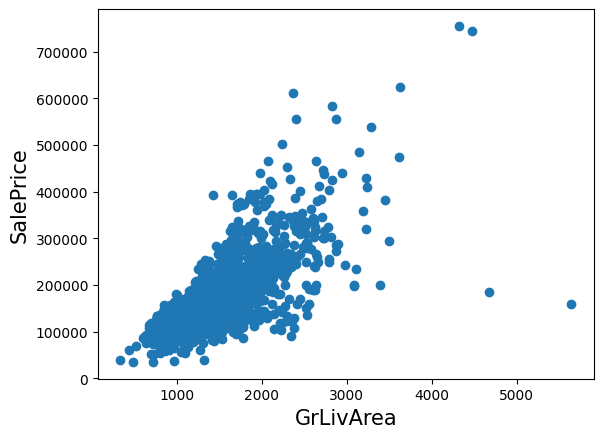

In [58]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

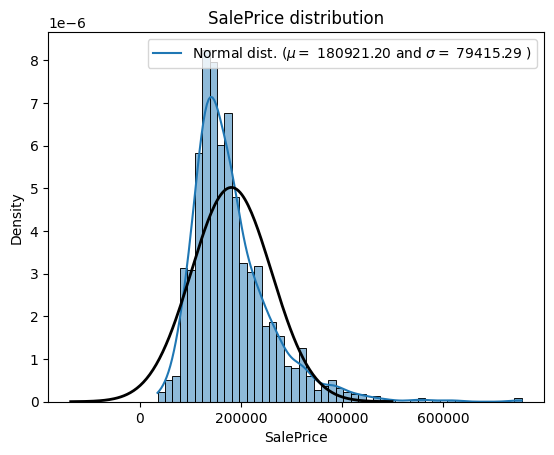

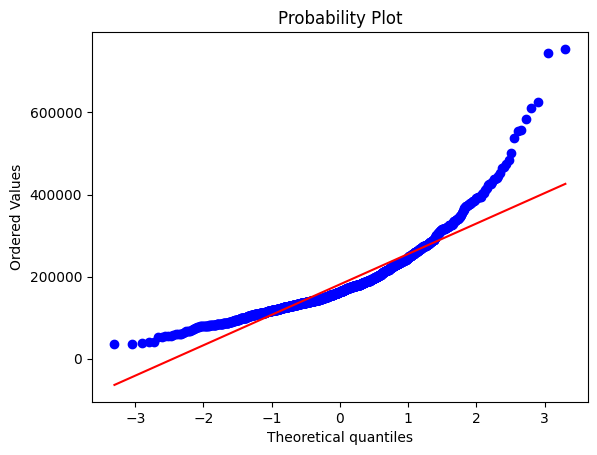

In [59]:
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = st.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)
ax = sns.histplot(x=train.SalePrice, stat='density', kde=True)
normal(train.SalePrice.mean(), train.SalePrice.std())

(mu, sigma) = st.norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.ylabel('Density')
plt.title('SalePrice distribution')

fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()

На графике видно, что данные распределены ненормально. Линейные модели предполагают, что данные будут распределены нормально. Следовательно, нам нужно преобразовать SalePrice так, чтобы она выглядела как нормальное распределение.

In [60]:
train["SalePrice"] = np.log1p(train["SalePrice"])

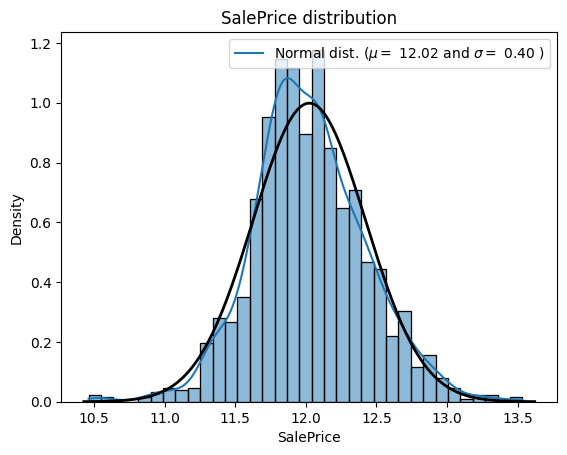

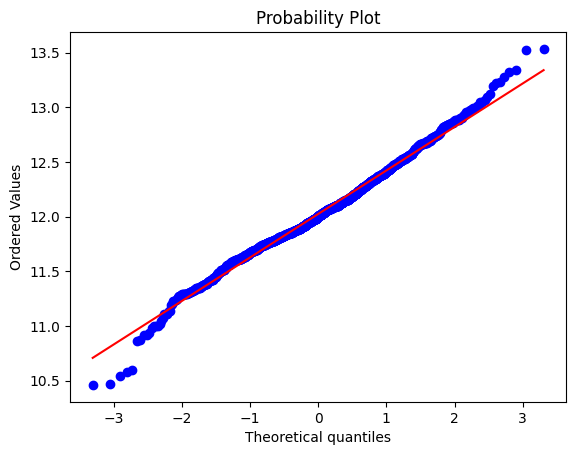

In [61]:
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = st.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)
ax = sns.histplot(x=train.SalePrice, stat='density', kde=True)
normal(train.SalePrice.mean(), train.SalePrice.std())

(mu, sigma) = st.norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.ylabel('Density')
plt.title('SalePrice distribution')

fig = plt.figure()
res = st.probplot(train['SalePrice'], plot=plt)
plt.show()

In [62]:
#train_X = train.drop(['SalePrice'], axis=1)
#train_y = train.SalePrice
#test_X = test